## Предсказание humidity - влажности на основании других погодных характеристик

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import nltk
import scipy.stats as stats

from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

from functools import partial

In [21]:
df = pd.read_csv('data.csv')
df

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,Partly Cloudy,rain,9.472222,7.388889,0.89,NaN,251.0,15.8263,NaN,1015.13,Partly cloudy throughout the day.
1,Partly Cloudy,rain,9.355556,NaN,0.86,14.2646,259.0,15.8263,NaN,1015.63,Partly cloudy throughout the day.
2,Mostly Cloudy,rain,NaN,9.377778,0.89,3.9284,204.0,14.9569,NaN,1015.94,Partly cloudy throughout the day.
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,NaN,1016.41,Partly cloudy throughout the day.
4,NaN,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,NaN,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...
96448,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,NaN,1014.36,Partly cloudy starting in the morning.
96449,NaN,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,NaN,1015.16,Partly cloudy starting in the morning.
96450,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,NaN,1015.66,Partly cloudy starting in the morning.
96451,NaN,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,NaN,1015.95,Partly cloudy starting in the morning.


In [ ]:
# посмотрим количество пропусков в каждом из столбцов
df.isna().sum()

"""
коичество пропусков:
Loud Cover 77103/96453 (79.9%)
Summary 29083/96453 (30.1%)
Temperature (C) 19293/96453 (20.0%)
Apparent Temperature (C) 9754/96453 (10.1%)
Wind Speed (km/h) 4835/96453 (5.0%)
Precip Type  517/96453 (0.5%)
"""

Summary                     29083
Precip Type                   517
Temperature (C)             19293
Apparent Temperature (C)     9754
Humidity                        0
Wind Speed (km/h)            4835
Wind Bearing (degrees)          0
Visibility (km)                 0
Loud Cover                  77103
Pressure (millibars)            0
Daily Summary                   0
dtype: int64

In [23]:
# замена градусов на направление движерия ветра
# работать с направлением удобнее, чем с градусами
def convert_deg_to_dir(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Wind Bearing (dir)'] = pd.cut(df['Wind Bearing (degrees)'],
                                          [x for x in np.arange(-0.5, 361, 45)],
                                          labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
                                          ordered=False)
    return df

In [24]:
# Bag of words
# создадим индикатеры для некоторых паттернов
def daily_summary_parse(df: pd.DataFrame) -> pd.DataFrame:

    contains = lambda data, name, num: data[name].str.contains(num).astype(int)

    df = df.copy()

# приведем к нижнему регистру
    df['Daily Summary'] = df['Daily Summary'].str.lower()
    df['Summary'] = df['Summary'].str.lower()

# оставим индикаторы partly_cloudy, mostly_cloudy, overcast, foggy, breezy
    df['partly_cloudy'] = contains(df, 'Daily Summary', 'partly cloudy')
    df['mostly_cloudy'] = contains(df, 'Daily Summary', 'mostly cloudy')
    df['overcast'] = contains(df, 'Daily Summary', 'overcast')
    df['foggy'] = contains(df, 'Daily Summary', 'foggy')
    df['breezy'] = contains(df, 'Daily Summary', 'breezy|windy')

    for breezy_factor in ['windy and dry', 'breezy and dry', 'windy and foggy',
                          'windy', 'windy and mostly cloudy', 'breezy and foggy',
                          'windy and overcast', 'breezy', 'windy and partly cloudy',
                          'breezy and partly cloudy', 'breezy and mostly cloudy',
                          'breezy and overcast']:
        df.loc[~df['Summary'].isna() & df['Summary'].str.match(breezy_factor), 'breezy'] = 1

    for partly_factor in ['partly cloudy', 'breezy and partly cloudy',
                          'dry and partly cloudy', 'windy and partly cloudy',
                          'humid and partly cloudy']:
        df.loc[~df['Summary'].isna() & df['Summary'].str.match(partly_factor), 'partly_cloudy'] = 1

    for mostly_factor in ['mostly cloudy', 'breezy and mostly cloudy',
                          'humid and mostly cloudy', 'windy and mostly cloudy',
                          'dry and mostly cloudy']:
        df.loc[~df['Summary'].isna() & df['Summary'].str.match(mostly_factor), 'mostly_cloudy'] = 1

    for overcast_factor in ['overcast', 'breezy and overcast',
                            'windy and overcast',
                            'humid and overcast']:
        df.loc[~df['Summary'].isna() & df['Summary'].str.match(overcast_factor), 'overcast'] = 1

    for foggy_factor in ['foggy', 'breezy and foggy', 'windy and foggy']:
        df.loc[~df['Summary'].isna() & df['Summary'].str.match(foggy_factor), 'foggy'] = 1


    return df.drop(['Summary', 'Daily Summary'], axis=1)

In [25]:
# разница фактической и ощущаемой температуры
# так же, теплее, холоднее по ощущениям

def temperature_diff(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    df['temp_diff'] = df['Temperature (C)'] - df['Apparent Temperature (C)']
    df['temp_diff_id'] = "=0"
    df.loc[df['temp_diff'] < 0, 'temp_diff_id'] = "<0"
    df.loc[df['temp_diff'] > 0, 'temp_diff_id'] = ">0"

    return df

In [26]:
# бинарныq признак-индикатор температура выше нуля или нет
def temperature_min_max(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    df.loc[df['Temperature (C)'] < 0, 'temp__id'] = 0
    df.loc[df['Temperature (C)'] >= 0, 'temp__id'] = 1

    return df

In [ ]:
# РАБОТА С ПРИЗНАКАМИ
"""
заполнеие пропусков, создание новых признаков, видоизменение и удаление старых
"""

# РАБОТА С ПРОПУСКАМИ

"""
удалим столбцы, в которых слишком много пропусков
в количественных признакоках посмотрим распределение,
если оно нормальное - заменим на среднее, иначе на медиану
некоторые пропуски заполним исходя из логики взаимосвязи

удалим столбцы, в которых пропусков больше 50% (Loud Cover)
"""
df = df.dropna(thresh = df.shape[0]//2, axis = 1)
df.shape

"""
# в температуре много пропусков, постараемся компенсировать это знаниями о типе осадков
# если снег - температура отрицательная, если дождь - полодительная
# заменим пропуски температуры при снеге - на среднее значние отрицательных температур
# при дожде - среднее значение положительных температур

"""

# mean_temp_min = df[df['temp_copy'] < 0, 'Temperature (C)'].mean()
# mean_temp_max = df[df['temp_copy'] >= 0, 'Temperature (C)'].mean()

# df[df['Precip Type'] == 'snow', 'Temperature (C)'] = mean_temp_min
# df[df['Precip Type'] == 'rain', 'Temperature (C)'] = mean_temp_max

# заменим занчения на медиану -  для распределения слишком далекого от нормального
df['Wind Speed (km/h)'] = df['Wind Speed (km/h)'].fillna(df['Wind Speed (km/h)'].median())

# заменим на среднее - хорошо для нормального распределения
# не все значения температуры получится заполнить логически
df['Temperature (C)'] = df['Temperature (C)'].fillna(df['Temperature (C)'].mean())
df['Apparent Temperature (C)'] = df['Apparent Temperature (C)'].fillna(df['Apparent Temperature (C)'].mean())

# заменим на моду - удобно использовать с категориальными признаками
df['Summary'] = df['Summary'].str.lower()
df['Summary'] = df['Summary'].fillna(df['Summary'].mode().iloc[0])

# заметим, что температура однозначно определет типа осадков (t >= 0 - rain; t < 0 - snow)
df.loc[df['Temperature (C)'] < 0, 'Precip Type'] = 'snow'
df.loc[df['Temperature (C)'] >= 0, 'Precip Type'] = 'rain'


# видоизменение и удаление признаков, для упрощения работы
df = daily_summary_parse(df)
df = convert_deg_to_dir(df)
df.drop_duplicates(inplace=True)

df = df.reset_index().drop('index', axis=1)
for category_col in ['Precip Type', 'Wind Bearing (dir)']:
    df[category_col] = df[category_col].astype('category')

for bool_col in ['partly_cloudy', 'mostly_cloudy', 'overcast', 'foggy', 'breezy']:
    df[bool_col] = df[bool_col].astype(bool)


# новые признаки
df = temperature_min_max(df)
df = temperature_diff(df)


df['mean_geom_temp'] = np.sqrt(abs(df['Temperature (C)'] * df['Apparent Temperature (C)']))
df['acceleration'] = df['Wind Speed (km/h)'] * df['Visibility (km)']

encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df[['Precip Type']]).toarray())
df = df.join(encoder_df, rsuffix='_encoder')

labelencoder = LabelEncoder()
df['temp_diff_id'] = labelencoder.fit_transform(df['temp_diff_id'])



# encoder_df = pd.DataFrame(encoder.fit_transform(df[['Wind Bearing (dir)']]).toarray())
# df = df.join(encoder_df, rsuffix='_encoder')

# df.columns

df.columns = ['Precip Type', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
              'Wind Speed (km/h)', 'Wind Bearing (degrees)','Visibility (km)',
              'Pressure (millibars)', 'partly_cloudy', 'mostly_cloudy','overcast',
              'foggy', 'breezy', 'Wind Bearing (dir)', 'temp__id', 'temp_diff',
              'temp_diff_id', 'mean_geom_temp', 'acceleration',
              'rain', 'snow']



/var/folders/n0/f9y337bd1svgssksnmpl7c2w0000gn/T/ipykernel_80034/4068328874.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Wind Speed (km/h)'] = df['Wind Speed (km/h)'].fillna(df['Wind Speed (km/h)'].median())
/var/folders/n0/f9y337bd1svgssksnmpl7c2w0000gn/T/ipykernel_80034/4068328874.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temperature (C)'] = df['Temperature (C)'].fillna(df['Temperature (C)'].mean())
/var/folders/n0/f9y337bd1svgssksnmpl7c2w0000gn/T/ipykernel_80034/4068328874.py:3

In [28]:
df

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),partly_cloudy,mostly_cloudy,...,foggy,breezy,Wind Bearing (dir),temp__id,temp_diff,temp_diff_id,mean_geom_temp,acceleration,rain,snow
0,rain,9.472222,7.388889,0.89,9.9498,251.0,15.8263,1015.13,True,False,...,False,False,SW,1.0,2.083333,2,8.365955,157.468520,1.0,0.0
1,rain,9.355556,10.885426,0.86,14.2646,259.0,15.8263,1015.63,True,False,...,False,False,SW,1.0,-1.529870,0,10.091541,225.755839,1.0,0.0
2,rain,11.904922,9.377778,0.89,3.9284,204.0,14.9569,1015.94,True,True,...,False,False,S,1.0,2.527144,2,10.566064,58.756686,1.0,0.0
3,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,True,False,...,False,False,SW,1.0,2.344444,2,7.019461,223.207805,1.0,0.0
4,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,True,False,...,False,False,SW,1.0,1.777778,2,7.816286,174.795153,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96423,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,1014.36,True,False,...,False,False,N,1.0,0.000000,1,26.016667,177.040430,1.0,0.0
96424,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,1015.16,True,False,...,False,False,N,1.0,0.000000,1,24.583333,156.998831,1.0,0.0
96425,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,1015.66,True,False,...,False,False,N,1.0,0.000000,1,22.038889,144.639180,1.0,0.0
96426,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,1015.95,True,False,...,False,False,N,1.0,0.000000,1,21.522222,169.523340,1.0,0.0


array([[<Axes: title={'center': 'Temperature (C)'}>,
        <Axes: title={'center': 'Apparent Temperature (C)'}>,
        <Axes: title={'center': 'Humidity'}>,
        <Axes: title={'center': 'Wind Speed (km/h)'}>],
       [<Axes: title={'center': 'Wind Bearing (degrees)'}>,
        <Axes: title={'center': 'Visibility (km)'}>,
        <Axes: title={'center': 'Pressure (millibars)'}>,
        <Axes: title={'center': 'temp__id'}>],
       [<Axes: title={'center': 'temp_diff'}>,
        <Axes: title={'center': 'temp_diff_id'}>,
        <Axes: title={'center': 'mean_geom_temp'}>,
        <Axes: title={'center': 'acceleration'}>],
       [<Axes: title={'center': 'rain'}>,
        <Axes: title={'center': 'snow'}>, <Axes: >, <Axes: >]],
      dtype=object)

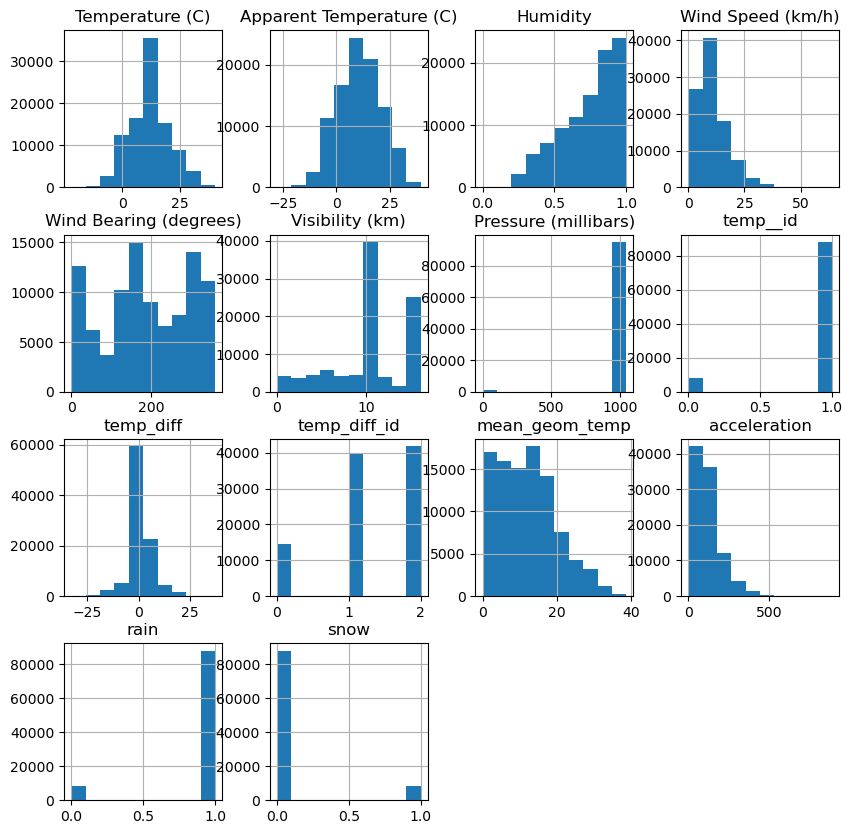

In [ ]:
# распределения признаков
df.hist(figsize=(10,10))

"""
Числовые: temp, apparent_temp, humidity, wind_speed_kmh, visibility_km, pressure
Категориальные: precip_type, wind_bearing_direction, pressure_label
Логически связаны между собой:
1. 'Temperature (C)' & 'Apparent Temperature (C)';
2. 'Humidity' & 'Temperature (C)';
"""

In [30]:
# функция дает информацию о выбросах
# методика построения boxplot
def sample_outliers(df: pd.DataFrame, feature: str):
    q1 = df[feature].describe()['25%']
    q3 = df[feature].describe()['75%']
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR

    result = { "lower": lower, "upper": upper,
        "outliers": df[(df[feature] < lower) | (df[feature] > upper)].shape[0]
    }
    return result


In [ ]:
# удаление выбросов
outliers = {}
name = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']
outliers = {}
for col in name:
    outliers[col] = sample_outliers(df, col)
    print(col, outliers[col])

for col in name:
    df = df.loc[((df[col] > outliers[col]['lower']) & (df[col] < outliers[col]['upper']))]

"""
Temperature (C): выбросов нет
Apparent Temperature (C): выбросов нет
Humidity: выбросы есть - влажность иногда даже 0
Wind Speed (km/h): выбросы есть - скорость иногда близка к урогану
Visibility (km): выбросов нет
Pressure (millibars): выбросы есть - много значений 0
"""

Temperature (C) {'lower': -10.030555555555559, 'upper': 33.50277777777778, 'outliers': 957}
Apparent Temperature (C) {'lower': -18.4, 'upper': 39.55555555555555, 'outliers': 104}
Humidity {'lower': 0.16499999999999992, 'upper': 1.3250000000000002, 'outliers': 46}
Wind Speed (km/h) {'lower': -5.667199999999999, 'upper': 25.759999999999998, 'outliers': 3523}
Visibility (km) {'lower': -1.3684999999999974, 'upper': 24.5203, 'outliers': 0}
Pressure (millibars) {'lower': 998.1149999999999, 'upper': 1034.875, 'outliers': 4399}


In [32]:
df

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),partly_cloudy,mostly_cloudy,...,foggy,breezy,Wind Bearing (dir),temp__id,temp_diff,temp_diff_id,mean_geom_temp,acceleration,rain,snow
0,rain,9.472222,7.388889,0.89,9.9498,251.0,15.8263,1015.13,True,False,...,False,False,SW,1.0,2.083333,2,8.365955,157.468520,1.0,0.0
1,rain,9.355556,10.885426,0.86,14.2646,259.0,15.8263,1015.63,True,False,...,False,False,SW,1.0,-1.529870,0,10.091541,225.755839,1.0,0.0
2,rain,11.904922,9.377778,0.89,3.9284,204.0,14.9569,1015.94,True,True,...,False,False,S,1.0,2.527144,2,10.566064,58.756686,1.0,0.0
3,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,True,False,...,False,False,SW,1.0,2.344444,2,7.019461,223.207805,1.0,0.0
4,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,True,False,...,False,False,SW,1.0,1.777778,2,7.816286,174.795153,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96423,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,1014.36,True,False,...,False,False,N,1.0,0.000000,1,26.016667,177.040430,1.0,0.0
96424,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,1015.16,True,False,...,False,False,N,1.0,0.000000,1,24.583333,156.998831,1.0,0.0
96425,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,1015.66,True,False,...,False,False,N,1.0,0.000000,1,22.038889,144.639180,1.0,0.0
96426,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,1015.95,True,False,...,False,False,N,1.0,0.000000,1,21.522222,169.523340,1.0,0.0


/var/folders/n0/f9y337bd1svgssksnmpl7c2w0000gn/T/ipykernel_80034/4235178837.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr()


<Axes: >

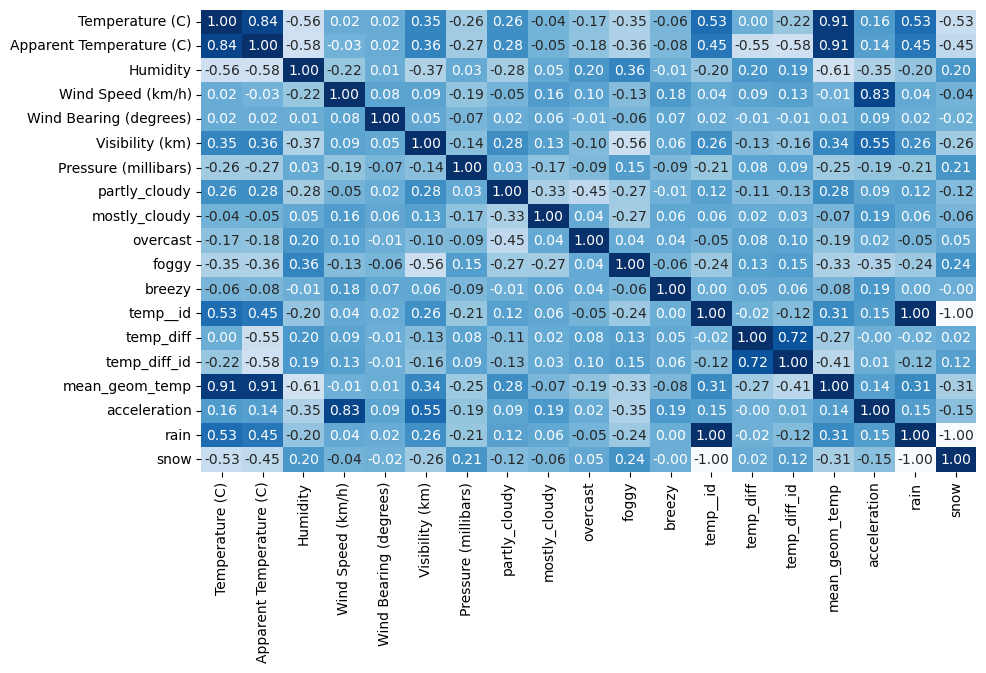

In [ ]:
# матрицa корреляций
corr_df = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='Blues', cbar=None)

# связаны между собой:
# 'Temperature (C)' & 'Apparent Temperature (C)'

In [34]:
# удаление высоко скорелированных между собой признаков

df.drop(['Apparent Temperature (C)', 'Temperature (C)'], axis=1, inplace=True)

# Apparent Temperature (C), так как имеет меньшую корреляцию с таргетом, чем Temperature (C)
# Temperature (C), так как имеет меньшую корреляцию с таргетом, чем mean_geom_temp


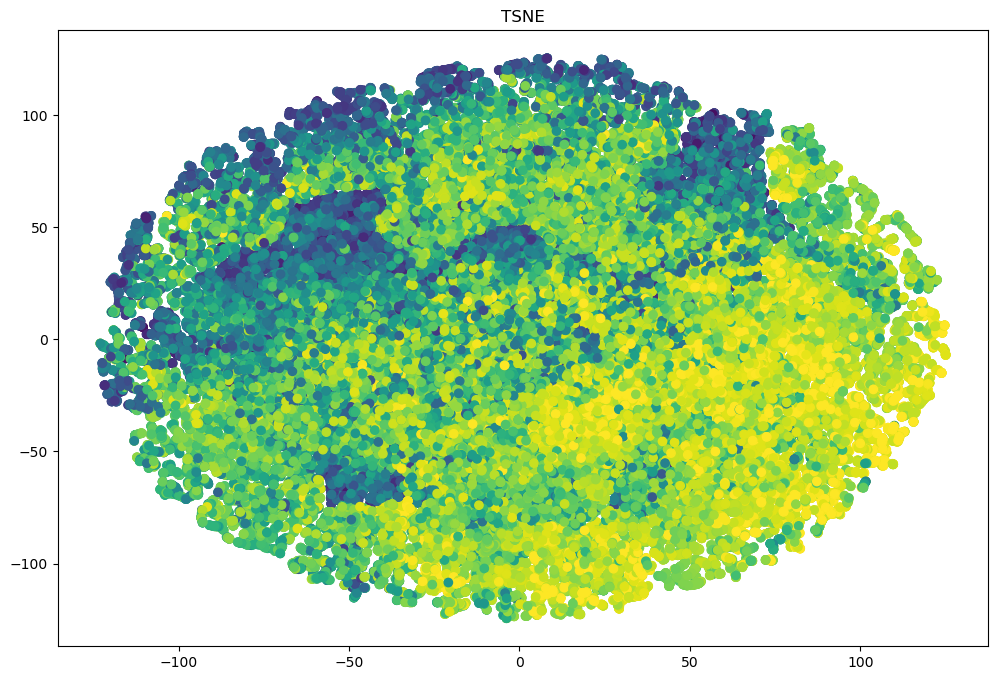

In [35]:
# TSNE
y = df['Humidity']
x_float = df[['mean_geom_temp', 'temp_diff', 'Wind Speed (km/h)',
              'Visibility (km)', 'Pressure (millibars)', 'temp__id',
             'snow', 'rain']]
scaled_x_float = StandardScaler().fit_transform(x_float)
tsne = TSNE(n_components=2, perplexity=5)
X_tsne = tsne.fit_transform(scaled_x_float)
plt.figure(figsize=(12, 8))
plt.title('TSNE')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.show()

In [36]:
df

,Precip Type,Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),partly_cloudy,mostly_cloudy,overcast,foggy,breezy,Wind Bearing (dir),temp__id,temp_diff,temp_diff_id,mean_geom_temp,acceleration,rain,snow
0,rain,0.89,9.9498,251.0,15.8263,1015.13,True,False,False,False,False,SW,1.0,2.083333,2,8.365955,157.468520,1.0,0.0
1,rain,0.86,14.2646,259.0,15.8263,1015.63,True,False,False,False,False,SW,1.0,-1.529870,0,10.091541,225.755839,1.0,0.0
2,rain,0.89,3.9284,204.0,14.9569,1015.94,True,True,False,False,False,S,1.0,2.527144,2,10.566064,58.756686,1.0,0.0
3,rain,0.83,14.1036,269.0,15.8263,1016.41,True,False,False,False,False,SW,1.0,2.344444,2,7.019461,223.207805,1.0,0.0
4,rain,0.83,11.0446,259.0,15.8263,1016.51,True,False,False,False,False,SW,1.0,1.777778,2,7.816286,174.795153,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96423,rain,0.43,10.9963,31.0,16.1000,1014.36,True,False,False,False,False,N,1.0,0.000000,1,26.016667,177.040430,1.0,0.0
96424,rain,0.48,10.0947,20.0,15.5526,1015.16,True,False,False,False,False,N,1.0,0.000000,1,24.583333,156.998831,1.0,0.0
96425,rain,0.56,8.9838,30.0,16.1000,1015.66,True,False,False,False,False,N,1.0,0.000000,1,22.038889,144.639180,1.0,0.0
96426,rain,0.60,10.5294,20.0,16.1000,1015.95,True,False,False,False,False,N,1.0,0.000000,1,21.522222,169.523340,1.0,0.0


In [ ]:
# разделим данные в соотношении 80:10:10
# 10% достаточно для проверки
# оставим больше данных для обучения

train_size=0.8
test_size = 0.5 # 50% of test/val

X = pd.get_dummies(df.drop('Humidity', axis=1))
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

array([[<Axes: title={'center': 'Wind Speed (km/h)'}>,
        <Axes: title={'center': 'Wind Bearing (degrees)'}>,
        <Axes: title={'center': 'Visibility (km)'}>,
        <Axes: title={'center': 'Pressure (millibars)'}>,
        <Axes: title={'center': 'temp__id'}>],
       [<Axes: title={'center': 'temp_diff'}>,
        <Axes: title={'center': 'temp_diff_id'}>,
        <Axes: title={'center': 'mean_geom_temp'}>,
        <Axes: title={'center': 'acceleration'}>,
        <Axes: title={'center': 'rain'}>],
       [<Axes: title={'center': 'snow'}>,
        <Axes: title={'center': 'Precip Type_rain'}>,
        <Axes: title={'center': 'Precip Type_snow'}>,
        <Axes: title={'center': 'Wind Bearing (dir)_N'}>,
        <Axes: title={'center': 'Wind Bearing (dir)_NE'}>],
       [<Axes: title={'center': 'Wind Bearing (dir)_E'}>,
        <Axes: title={'center': 'Wind Bearing (dir)_SE'}>,
        <Axes: title={'center': 'Wind Bearing (dir)_S'}>,
        <Axes: title={'center': 'Wind Bear

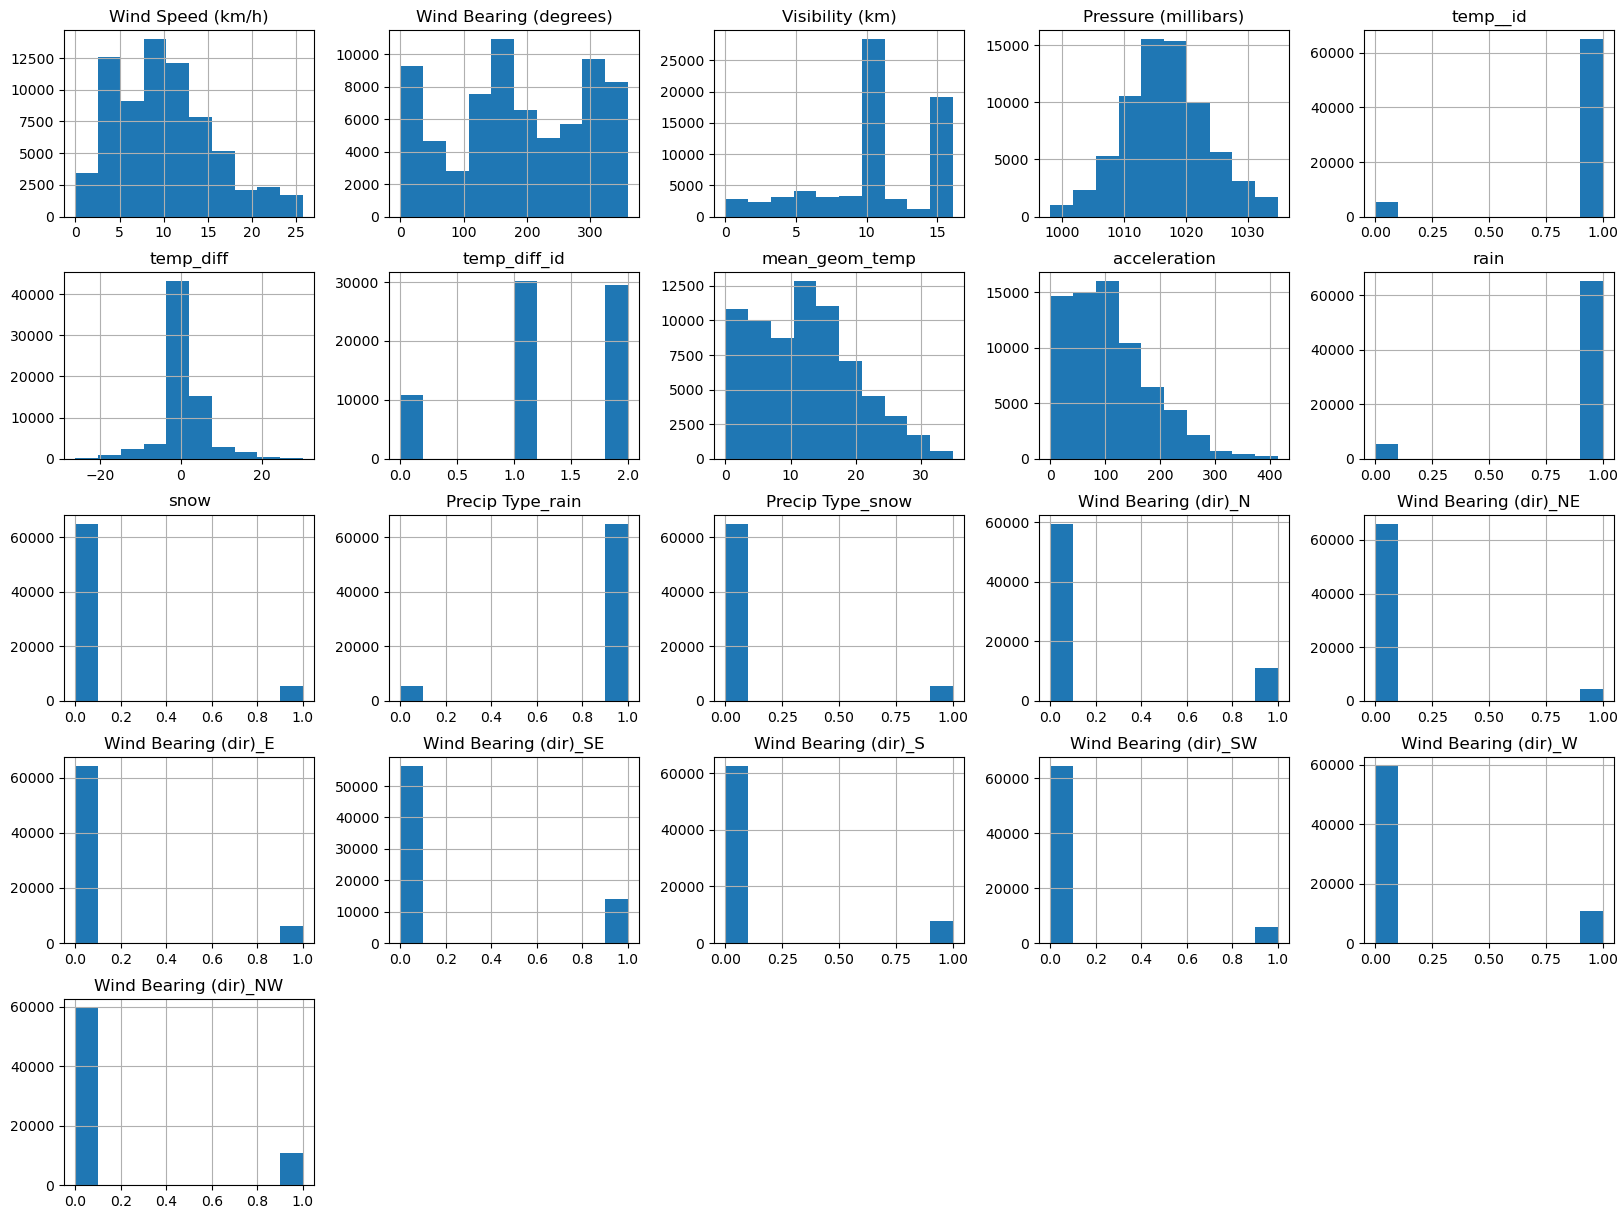

In [41]:
# убедимся в том, что распределение одинаковые
X_train.hist(figsize=(20, 15))

array([[<Axes: title={'center': 'Wind Speed (km/h)'}>,
        <Axes: title={'center': 'Wind Bearing (degrees)'}>,
        <Axes: title={'center': 'Visibility (km)'}>,
        <Axes: title={'center': 'Pressure (millibars)'}>,
        <Axes: title={'center': 'temp__id'}>],
       [<Axes: title={'center': 'temp_diff'}>,
        <Axes: title={'center': 'temp_diff_id'}>,
        <Axes: title={'center': 'mean_geom_temp'}>,
        <Axes: title={'center': 'acceleration'}>,
        <Axes: title={'center': 'rain'}>],
       [<Axes: title={'center': 'snow'}>,
        <Axes: title={'center': 'Precip Type_rain'}>,
        <Axes: title={'center': 'Precip Type_snow'}>,
        <Axes: title={'center': 'Wind Bearing (dir)_N'}>,
        <Axes: title={'center': 'Wind Bearing (dir)_NE'}>],
       [<Axes: title={'center': 'Wind Bearing (dir)_E'}>,
        <Axes: title={'center': 'Wind Bearing (dir)_SE'}>,
        <Axes: title={'center': 'Wind Bearing (dir)_S'}>,
        <Axes: title={'center': 'Wind Bear

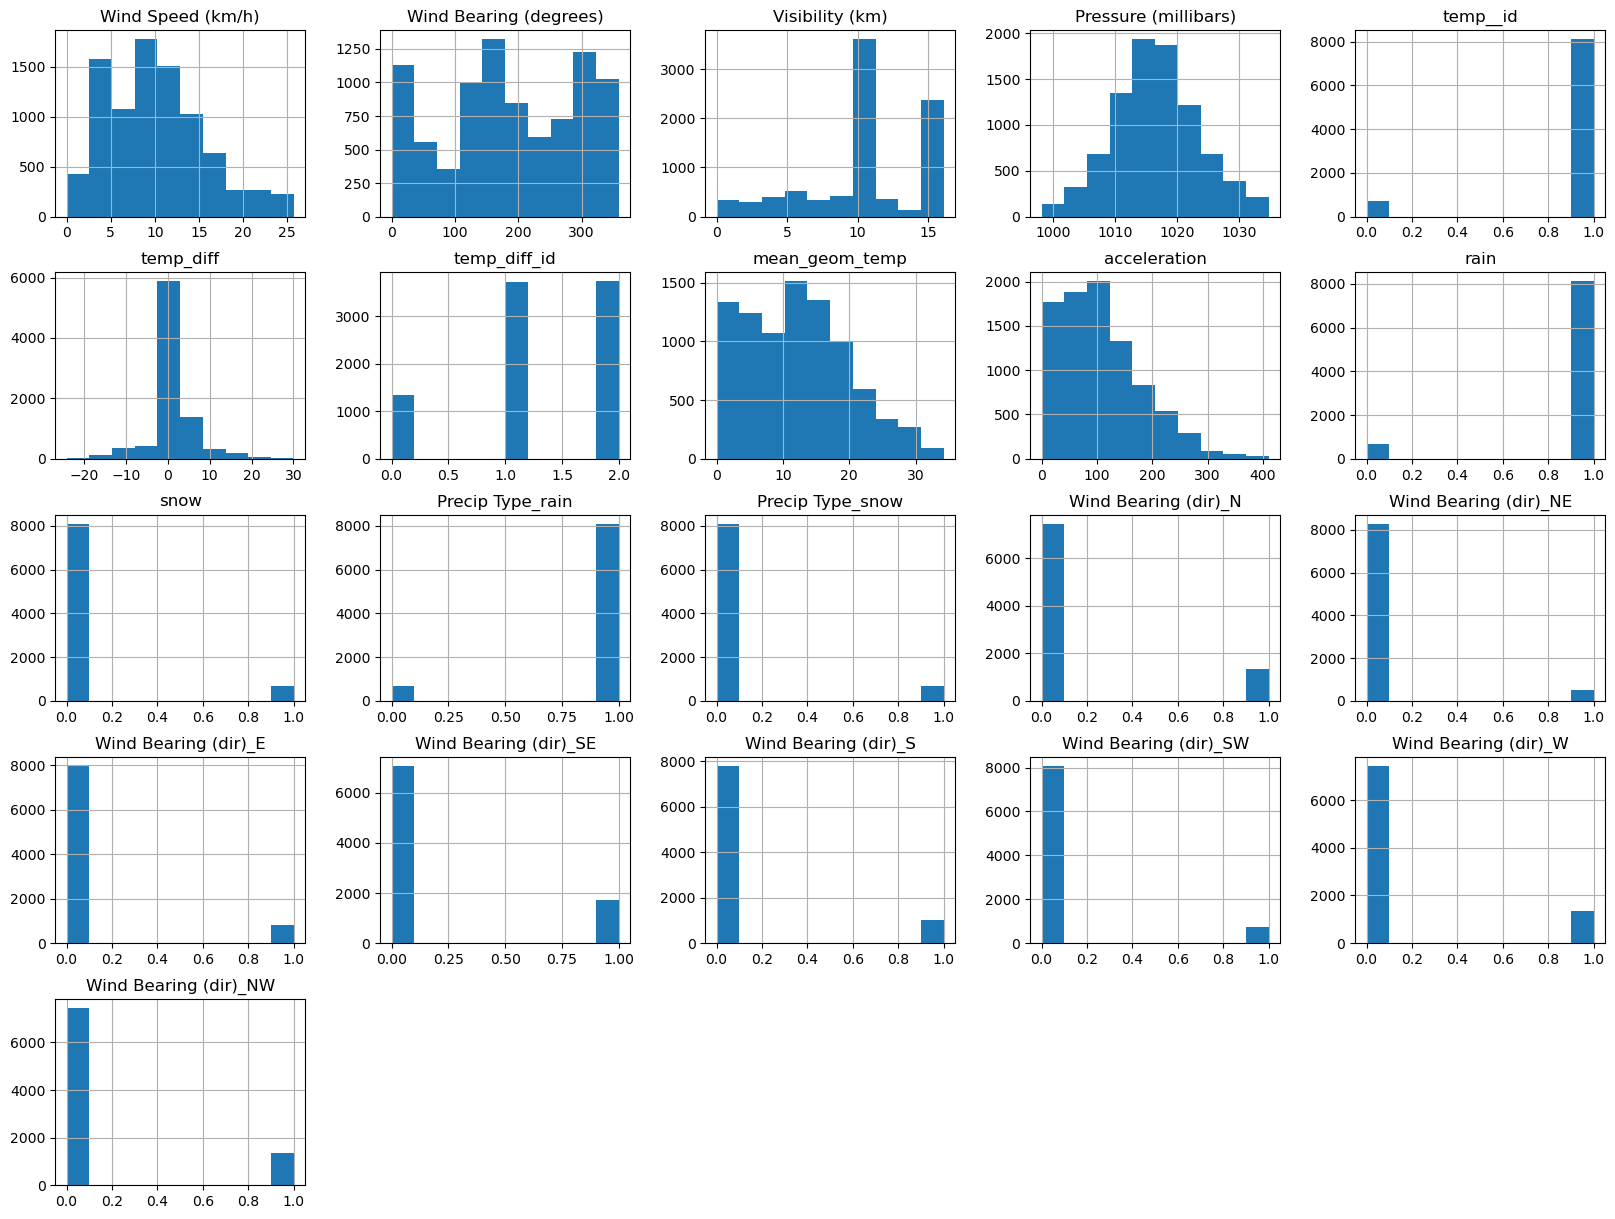

In [42]:
X_valid.hist(figsize=(20, 15))

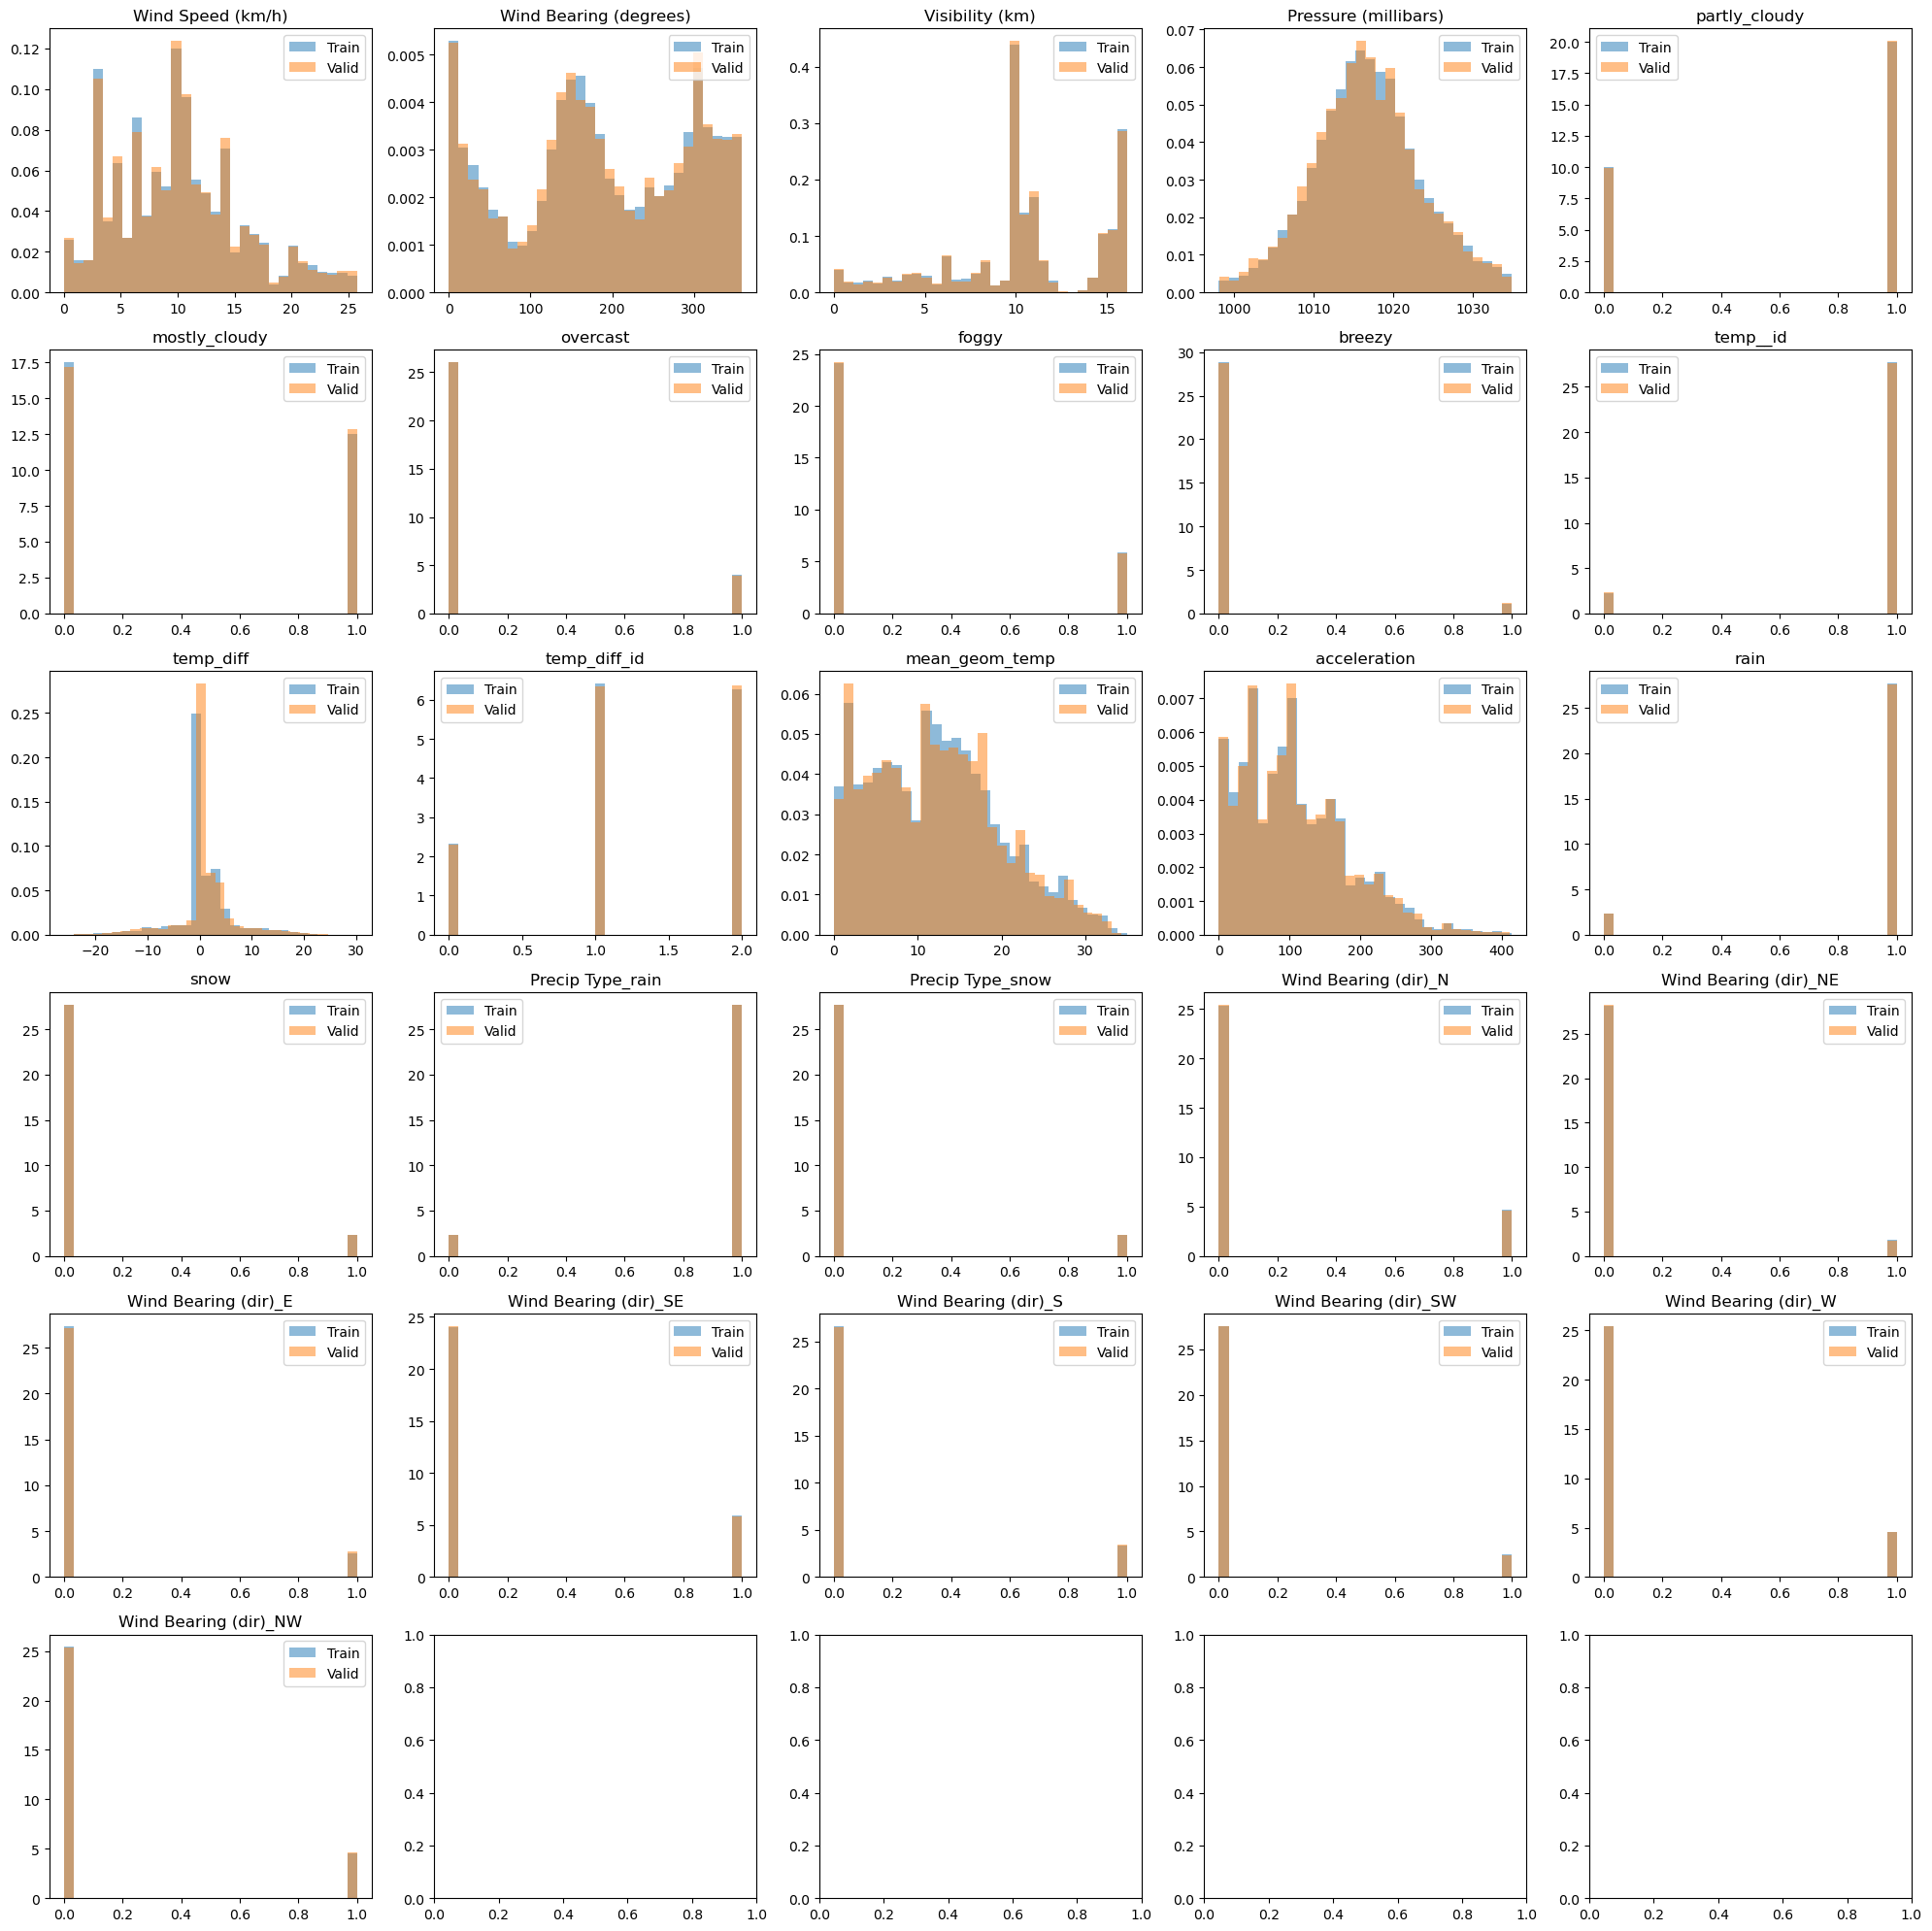

In [61]:
# Рассмотрим в налодении для большей наглядности и сравнимости распредлений.

X_train_numeric = X_train.astype(float)
X_valid_numeric = X_valid.astype(float)

fig, axes = plt.subplots(len(X_train_numeric.columns) // 4 , 5, figsize=(20, 20))
axes = axes.flatten()

for i, column in enumerate(X_train_numeric.columns):
    axes[i].hist(X_train_numeric[column], bins=30, alpha=0.5, label="Train", density=True)
    axes[i].hist(X_valid_numeric[column], bins=30, alpha=0.5, label="Valid", density=True)
    axes[i].set_title(column)
    axes[i].legend()

plt.tight_layout()
plt.show()



In [43]:
reg = LinearRegression().fit(X_train, y_train)
mean_absolute_error(y_test, reg.predict(X_test))

0.10597947011371582

In [44]:
reg = Lasso().fit(X_train, y_train)
print(mean_absolute_error(y_test, reg.predict(X_test)))
np.array(X_train.columns)[reg.coef_ != 0]

0.1498468023547385


array(['acceleration'], dtype=object)

In [45]:
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train, y_train)
mean_absolute_error(y_test, clf.predict(X_test))

0.07389415975457334

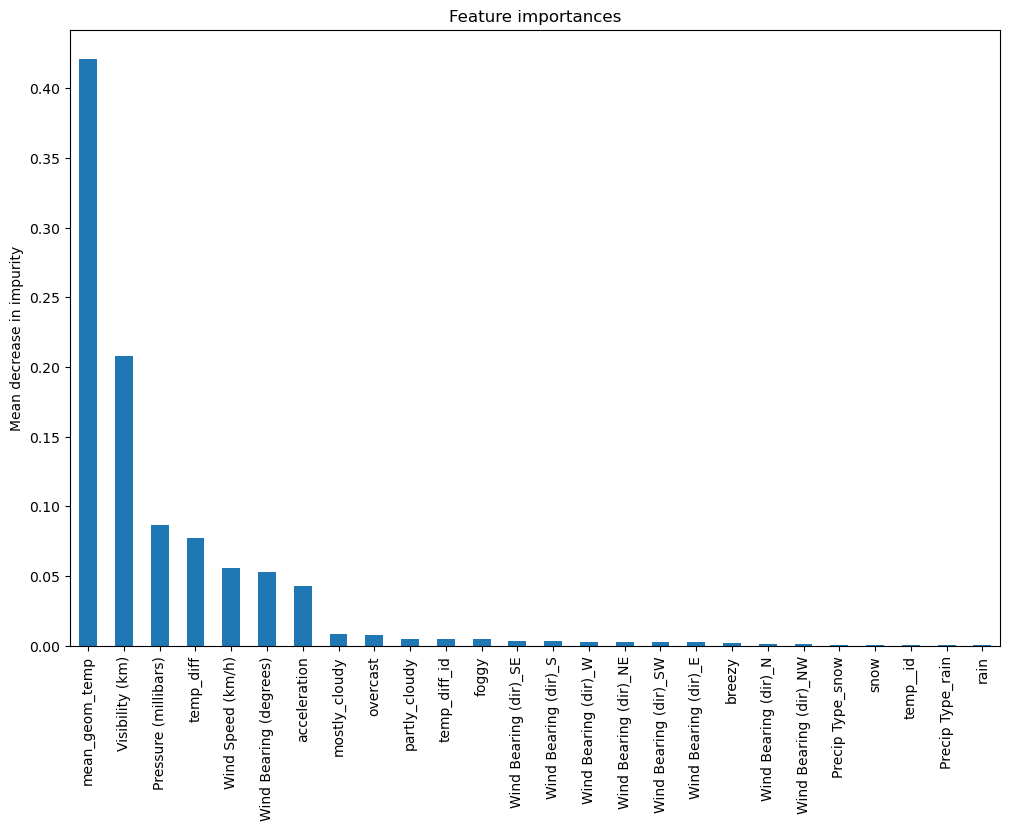

In [46]:
forest_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
forest_importances = forest_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
forest_importances.plot.bar()
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity")
plt.show()

In [64]:
pd.get_dummies(df).corr()['Humidity']

Humidity                  1.000000
Wind Speed (km/h)        -0.218142
Wind Bearing (degrees)    0.010630
Visibility (km)          -0.365317
Pressure (millibars)      0.025975
partly_cloudy            -0.280558
mostly_cloudy             0.049826
overcast                  0.203225
foggy                     0.355238
breezy                   -0.005566
temp__id                 -0.200213
temp_diff                 0.197308
temp_diff_id              0.193349
mean_geom_temp           -0.608158
acceleration             -0.351970
rain                     -0.200213
snow                      0.200213
Precip Type_rain         -0.200213
Precip Type_snow          0.200213
Wind Bearing (dir)_N     -0.019668
Wind Bearing (dir)_NE    -0.015623
Wind Bearing (dir)_E     -0.001046
Wind Bearing (dir)_SE     0.023090
Wind Bearing (dir)_S      0.000296
Wind Bearing (dir)_SW     0.002994
Wind Bearing (dir)_W      0.000781
Wind Bearing (dir)_NW     0.002036
Name: Humidity, dtype: float64

In [65]:
clf = CatBoostRegressor(random_state=42, silent=True)
clf.fit(X_train, y_train)
mean_absolute_error(y_test, clf.predict(X_test))

0.07514979381228777